# COBRApy

COBRApy is a package for constraint-based modeling of biological networks written in Python.

This tool allows loading and inspecting Genome-Scale Metabolic (GEM) models written in the Sytems Biology Markup Language (SBML) format.

Using COBRApy, one can analyse the following model contents:
1. Reactions
2. Metabolites
3. Genes
4. Exchange reactions (Environmental Conditions)

COBRApy allows manipulating the contents of a GEM model. For instance, one can edit reactions' flux bounds, knock out a metabolic gene, or change the environmental conditions.

Phenotype prediction can be simulated with several flux analysis methods implemented in COBRApy. These include Flux Balance Anlysis (FBA), Parsimonious FBA, or Flux Variability Analysis (FVA).

The simulation of gene and reaction deletions for a given GEM model is a simple and straightforward process. One can simulate single or double knock outs using one of the flux analysis methods mentioned above.

## Instalation


### Requirements
The following requirements need to be installed to use COBRApy:
- Python 3.6 or higher
- pip must be installed
- GLPK solver is used by default but CPLEX is prefered


### How to install COBRApy?
```
pip install cobra
```

# Exercise 5 - Phenotype prediction

## Working with a GEM model

For this practical session, we will be using the following model:
- _iMM904_ model which contains the whole metabolism of _S. cerevisiae_ -> file: ../data/iMM904.xml

This exercise consists of exploring the phenotype prediction tools of COBRApy. Thus, the following steps will be followed:
- Loading the model with COBRApy;
- Perform a FBA simulation using an aerobic/anaerobic medium;
- Perform reaction and gene deletions
- Perform other flux analysis methods, such as pFBA, FVA, ROOM and MOMA;
- Analyzing the model essential 

In [1]:
# importing cobra
import cobra

# Loading a model
model_path = '../data/iMM904.xml'
model = cobra.io.read_sbml_model(model_path)

model

Name,iMM904
Memory address,0x0246223cac48
Number of metabolites,1226
Number of reactions,1577
Number of groups,0
Objective expression,1.0*BIOMASS_SC5_notrace - 1.0*BIOMASS_SC5_notrace_reverse_93090
Compartments,"cytosol, extracellular space, mitochondria, peroxisome/glyoxysome, endoplasmic reticulum, vacuole, golgi apparatus, nucleus"


### Phenotype Prediction

#### Flux Balance Analysis (FBA) - Aerobiose

In [2]:
#check model exchanges
for exchange in model.exchanges:
    print(exchange.name, '->', exchange.bounds)

Episterol ester  yeast specific exchange -> (0.0, 999999.0)
Episterol exchange -> (0.0, 999999.0)
Ergosterol exchange -> (0.0, 999999.0)
Ergosterol ester  yeast specific exchange -> (0.0, 999999.0)
1 3 beta D Glucan exchange -> (0.0, 999999.0)
Ethanolamine exchange -> (0.0, 999999.0)
2 Hydroxybutyrate exchange -> (0.0, 999999.0)
Ethanol exchange -> (0.0, 999999.0)
Fe2+ exchange -> (-999999.0, 999999.0)
Fecosterol exchange -> (0.0, 999999.0)
2 methylbutyl acetate exchange -> (0.0, 999999.0)
2 methylbutyraldehyde exchange -> (0.0, 999999.0)
2 methyl 1 butanol exchange -> (0.0, 999999.0)
2 methylpropanal exchange -> (0.0, 999999.0)
2 phenylethanol exchange -> (0.0, 999999.0)
Fecosterol ester  yeast specific exchange -> (0.0, 999999.0)
FMN exchange -> (0.0, 999999.0)
3 Carboxy 3 hydroxy 4 methylpentanoate exchange -> (0.0, 999999.0)
3 Methylbutanal exchange -> (0.0, 999999.0)
Formate exchange -> (0.0, 999999.0)
D-Fructose exchange -> (0.0, 999999.0)
3mop exchange -> (0.0, 999999.0)
4-Amino

In [3]:
#Perform a FBA with aerobic conditions
aerobic_solution = model.optimize()
aerobic_solution

,fluxes,reduced_costs
CITtcp,0.000000,-3.469447e-18
13BGH,0.000000,-4.751566e-02
13BGHe,0.000000,0.000000e+00
13GS,0.326670,0.000000e+00
16GS,0.000000,-9.503132e-02
...,...,...
PYDXO,0.000000,0.000000e+00
PYK,17.721990,0.000000e+00
PYNP2r,0.000000,-0.000000e+00
PYR5CDm,0.000000,-2.969729e-02


In [4]:
model.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
glc__D_e,EX_glc__D_e,10,6,100.00%
nh4_e,EX_nh4_e,1.611,0,0.00%
o2_e,EX_o2_e,2,0,0.00%
pi_e,EX_pi_e,0.05691,0,0.00%
so4_e,EX_so4_e,0.02225,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
co2_e,EX_co2_e,-18.02,1,36.29%
etoh_e,EX_etoh_e,-15.82,2,63.70%
for_e,EX_for_e,-0.001488,1,0.00%
h2o_e,EX_h2o_e,-5.64,0,0.00%


#### Flux Balance Analysis (FBA) - Anaerobiose

In [5]:
#setting the environmental conditions to replicate an anaerobic medium
o2 = model.reactions.get_by_id('EX_o2_e')
o2.bounds = (0,1000)
o2

Reaction identifier,EX_o2_e
Name,O2 exchange
Memory address,0x2462ad9aec8
Stoichiometry,o2_e --> O2 O2 -->
GPR,
Lower bound,0
Upper bound,1000


In [6]:
#Perform a FBA with anaerobic conditions
anaerobic_solution = model.optimize()
anaerobic_solution

,fluxes,reduced_costs
CITtcp,0.0,-0.0
13BGH,0.0,0.0
13BGHe,0.0,0.0
13GS,0.0,0.0
16GS,0.0,0.0
...,...,...
PYDXO,0.0,0.0
PYK,1.0,0.0
PYNP2r,0.0,0.0
PYR5CDm,0.0,0.0


#### Parsimonious Flux Balance Analysis (pFBA)

In [23]:
#setting the environmental conditions to replicate an aerobic medium
o2 = model.reactions.get_by_id('EX_o2_e')
o2.bounds = (-2,1000)
o2

Reaction identifier,EX_o2_e
Name,O2 exchange
Memory address,0x2462ad9aec8
Stoichiometry,o2_e <=> O2 O2 <=>
GPR,
Lower bound,-2
Upper bound,1000


In [8]:
#performing pfba simulation
pfba_solution = cobra.flux_analysis.pfba(model)
pfba_solution

,fluxes,reduced_costs
CITtcp,0.000000,-2.0
13BGH,0.000000,444.0
13BGHe,0.000000,-2.0
13GS,0.326670,-2.0
16GS,0.000000,-2.0
...,...,...
PYDXO,0.000000,-2.0
PYK,17.721990,-2.0
PYNP2r,0.000000,-2.0
PYR5CDm,0.000000,270.0


#### Double Delections

In [9]:
#double reaction deletion
double_reaction_deletion_results = cobra.flux_analysis.single_reaction_deletion(model)
double_reaction_deletion_results

,ids,growth,status
0,{CBASPtn},2.878657e-01,optimal
1,{XANt},2.878657e-01,optimal
2,{PIN3K_SC},2.878657e-01,optimal
3,{ERGSTter},-1.507794e-16,optimal
4,{FA260tp},2.878657e-01,optimal
...,...,...,...
1572,{OAAt},2.878657e-01,optimal
1573,{DMATT},-5.811155e-16,optimal
1574,{ADHAPR_SC},2.878657e-01,optimal
1575,{THMP},2.878657e-01,optimal


In [10]:
#double gene deletion
double_gene_deletion_results = cobra.flux_analysis.single_gene_deletion(model)
double_gene_deletion_results

,ids,growth,status
0,{YNL106C},2.878657e-01,optimal
1,{YHR025W},4.862428e-16,optimal
2,{YOR065W},2.093293e-01,optimal
3,{YJL137C},2.878657e-01,optimal
4,{YPR036W},2.878657e-01,optimal
...,...,...,...
900,{YDL171C},2.878657e-01,optimal
901,{YGR282C},2.878657e-01,optimal
902,{YDR268W},2.878657e-01,optimal
903,{YNL292W},2.878657e-01,optimal


### Production envelopes

<AxesSubplot:xlabel='BIOMASS_SC5_notrace'>

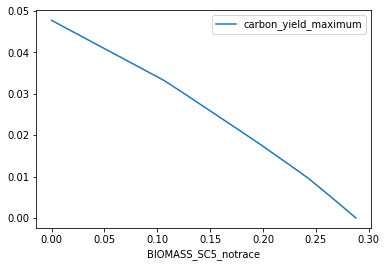

In [26]:
#obtain a plot of a production envelope using glucose as carbon source and optimizing Acetate production
prod_env = cobra.flux_analysis.production_envelope(model, ["BIOMASS_SC5_notrace"], objective="EX_for_e", carbon_sources="EX_glc__D_e")
prod_env.plot(kind='line', x='BIOMASS_SC5_notrace', y='carbon_yield_maximum')

### Pathway Visualization

In [13]:
# first import escher
import escher

In [14]:
# create the builder object wich contains the metabolic map
builder_aerobic = escher.Builder(map_name='iMM904.Central carbon metabolism', model=model, reaction_data=aerobic_solution.fluxes)
builder_aerobic

Builder(reaction_data={'CITtcp': 0.0, '13BGH': 0.0, '13BGHe': 0.0, '13GS': 0.3266700005633196, '16GS': 0.0, '2…

In [ ]:
o2 = model.reactions.get_by_id('EX_o2_e')
o2.bounds = (0,1000)
anaerobic_solution = model.optimize()
anaerobic_solution

In [ ]:
builder_anaerobic = escher.Builder(map_name='iMM904.Central carbon metabolism', model=model, reaction_data=anaerobic_solution.fluxes)
builder_anaerobic

In [29]:
builder_anaerobic = escher.Builder(map_name='iMM904.Central carbon metabolism', model=model, reaction_data=anaerobic_solution.fluxes)
builder_anaerobic

Builder(reaction_data={'CITtcp': 0.0, '13BGH': 0.0, '13BGHe': 0.0, '13GS': 1.8346911643343266e-16, '16GS': 0.0…